---
title: Model validity - regression assumptions
teaching: 45
exercises: 2
keypoints:
- "All models are wrong, but some are useful."
- "Before reading into a model's estimated coefficients, modelers must take care to check for evidence of overfitting and assess the 5 assumptions of linear regression."
- "One-hot enoding, while necesssary, can often produce very sparse binary predictors which have little information. Predictors with very little variability should be removed prior to model fitting."
objectives:
- "Understand how to assess the validity of a multivariate regression model." 
- "Understand how to use statistics to evaluate the likelihood of existing relationships recovered by a multivariate model."
questions:
- "How can multivariate models be used to detect interesting relationships found in nature?"
- "What are the assumptions of linear regression models?"
- "How can we rigorously evaluate the validity and accuracy of a multivariate regression model?"
- "How should we preprocess categorical predictors and sparse binary predictors?"
---

### Model Validity And Interpretation
While using models strictly for predictive purposes is a completely valid approach for some domains and problems, researchers typically care more about being able to interpret their models such that interesting relationships between predictor(s) and target can be discovered and measured. When interpretting a linear regression model, we can look at the model's estimated coefficients and p-values associated with each predictor to better understand the model. The coefficient's magnitude can inform us of the effect size associated with a predictor, and the p-value tells us whether or not a predictor has a consistent (statistically significant) effect on the target. 

**Before we can blindly accept the model's estimated coefficients and p-values, we must answer three questions that will help us determine whether or not our model is valid.**

#### Model Validity Assessments
1. **Accounting for relevant predictors**: Have we included as many relevant predictors in the model as possible?
2. **Bias/variance or under/overfitting**: Does the model capture the variability of the target variable well? Does the model generalize well?
3. **Model assumptions**: Does the fitted model follow the 5 assumptions of linear regression?

We will discuss the third assessment — regression assumptions — in detail throughout this episode.

### Linear regression assumptions
The main goal of linear regression is to model the relationship between the target variable and the predictor variables using a linear equation. The assumptions that are typically discussed in the context of linear regression are related to how well this linear model represents the underlying data-generating process. These assumptions ensure that the linear regression estimates are accurate, interpretable, and can be used for valid statistical inference. 

When interpretting multivariate models (coefficient size and p-values), the following assumpitons should be met to assure validty of results.
1. **Linearity**: There is a linear relation between Y and X
2. **Normality**: The error terms (residuals) are normally distributed
3. **Homoscedasticity**: The variance of the error terms is constant over all X values (homoscedasticity)
4. **Independence**: The error terms are independent
5. **Limited multicollinearity among predictors**: This assumption applies to multivariate regression models but is not relevant in univariate regression since there is only one predictor variable. Multicollinearity refers to the presence of high correlation or linear dependence among the predictor variables in a regression model. It indicates that there is a strong linear relationship between two or more predictor variables. Multicollinearity can make it challenging to isolate the individual effects of predictors and can lead to unstable and unreliable coefficient estimates. It primarily focuses on the relationships among the predictors themselves. 

We will explore assess all five assumptions using a multivariate model built from the Ames housing data.

### 0. Load and prep data

In [1]:
from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True, parser='auto') #

In [2]:
y=housing['target']

#### Log scale SalePrices
In our previous univariate models, we observed that several predictors tend to linearly relate more with the log version of SalePrices. Target variables that exhibit an exponential trend, as we observe with house prices, typically need to be log scaled in order to observe a linear relationship with predictors that scale linearly. For this reason, we'll log scale our target variable here as well.

In [3]:
import numpy as np
y_log = y.apply(np.log)

#### Set predictors
Let's assume we have two predictors recorded in this dataset — sale condition and OverallQual (don't worry, we'll use many more predictors in the next few episodes!). What values can the sale condition variable take?

In [4]:
cat_predictor = 'SaleCondition'
predictors = ['OverallQual', cat_predictor]
X=housing['data'][predictors]
print(X.head())
print(X[cat_predictor].unique())

   OverallQual SaleCondition
0            7        Normal
1            6        Normal
2            7        Normal
3            7       Abnorml
4            8        Normal
['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']


SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

#### Encode categorical data as multiple binary predictors

In [5]:
import pandas as pd
# one-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(X[cat_predictor])
one_hot.head()

,Abnorml,AdjLand,Alloca,Family,Normal,Partial
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,1,0,0,0,0,0
4,0,0,0,0,1,0


In [6]:
# Join the encoded df
X = X.join(one_hot)

# Drop column SaleCondition as it is now encoded
X = X.drop(cat_predictor,axis = 1)
X.head()


,OverallQual,Abnorml,AdjLand,Alloca,Family,Normal,Partial
0,7,0,0,0,0,1,0
1,6,0,0,0,0,1,0
2,7,0,0,0,0,1,0
3,7,1,0,0,0,0,0
4,8,0,0,0,0,1,0


#### Handling sparse binary predictors
After we've split our category variable into 6 binary predictors, it is important to assess the quantity of information present in each predictor. If a predictor shows very little variability (e.g., nearly all 0's or 1's in a binary variable), then it will be challenging to detect a meaningful relationship between that predictor and the target. The model needs to observe examples from both classes of a binary variable in order to reveal a measurable effect between a binary variable and the target.

To assess the degree or sparsity in each binary predictor, we'll calculate the count and total percentage of observations where a 1 occurs.

In [7]:
nonzero_counts = X.astype(bool).sum()
print(nonzero_counts)
print(nonzero_counts/X.shape[0]*100)

OverallQual    1460
Abnorml         101
AdjLand           4
Alloca           12
Family           20
Normal         1198
Partial         125
dtype: int64
OverallQual    100.000000
Abnorml          6.917808
AdjLand          0.273973
Alloca           0.821918
Family           1.369863
Normal          82.054795
Partial          8.561644
dtype: float64


A few of the predictors (AdjLand, Alloca, Family) contain very little information since they are filled almost entirely with 0's. With few observations to rely on, this makes it difficult to assess how house price changes when these predictors become active (1 instead of 0). If you encounter extremely sparse predictors, it's best to remove them from the start to avoid wasting computational resources. You can use a percentage threshold or a total count threshold to refine the list of viable/studyable predictors. Here, we'll remove predictors that don't have at least 20 observations. The exact threshold chosen is somewhat arbitrary. It's more important that you follow-up this choice with a thorough investigation of the resulting model and adjust the model downstream, if necessary.

In [8]:
X = X.drop(['AdjLand', 'Alloca'], axis = 1)
# X = X.drop(['Family','AdjLand', 'Alloca'], axis = 1)
X.head()

,OverallQual,Abnorml,Family,Normal,Partial
0,7,0,0,1,0
1,6,0,0,1,0
2,7,0,0,1,0
3,7,1,0,0,0
4,8,0,0,1,0


### 2. Check for multicollinearity 

**Multicollinearity**: In statistics, multicollinearity is a phenomenon in which one or more predictors in a multivariate regression model can be linearly predicted from the others with a substantial degree of accuracy. In other words, it means that one or more predictors are highly correlated with one another.

Multicollinearity presents a problem in multivariate regression because, without having independent/uncorrelated predictors, it is difficult to know how much each predictor truly contributes to predicting the target variable. In other words, when two or more predictors are closely related or measure almost the same thing, then the underlying impact on the target varible is being accounted for twice (or more) across the predictors.

***While multicollinearity does not reduce a model's overall predictive power, it can produce estimates of the regression coefficients that are not statistically valid.***

#### Variance Inflation Factor (VIF) 
The **VIF (Variance Inflation Factor)** is a statistical measure used to detect multicollinearity in regression analysis. VIF helps to quantify the extent to which multicollinearity is present in the model.

The intuition behind the VIF score is based on the idea that if two or more predictor variables are highly related, it becomes difficult for the model to distinguish the individual effects of these variables on the dependent variable. Consequently, the coefficient estimates for these variables become unstable, and their standard errors become inflated, making the results less reliable.

The VIF is calculated for each independent variable in the regression model. Specifically, to calculate the VIF for predictor i, the following steps are taken:

1. Fit a regression model with predictor variable i as the target/dependent variable and all other independent variables (excluding i) as predictors.

2. Calculate the R-squared value (R²) for this regression model. R² represents the proportion of variance in variable i that can be explained by the other independent variables.

3. Calculate the VIF for variable i using the formula: VIF(i) = 1 / (1 - R²)

4. The interpretation of the VIF score is as follows:

    * A VIF of 1 indicates that there is no multicollinearity for the variable, meaning it is not correlated with any other independent variable in the model.

    * VIF values between 1 and 5 (or an R² between 0 and .80) generally indicate low to moderate multicollinearity, which is typically considered acceptable in most cases.

    * VIF values greater than 5 (some sources use a threshold of 10) suggest high multicollinearity, indicating that the variable is highly correlated with other independent variables, and its coefficient estimates may be unreliable.

We can calculate VIF for all predictors quickly using the variance_inflation_factor function from the statsmodels package.

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_print_VIF(X):
    # Calculate VIF for each predictor in X
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Display the VIF values
    print(vif)

In [10]:
calc_print_VIF(X)

      Variable        VIF
0  OverallQual  19.518808
1      Abnorml   2.072691
2       Family   1.229967
3       Normal  15.774223
4      Partial   3.441928


It looks like two of the predictors, "Normal" and "OverallQual", have high VIF scores. We can further investigate this score by creating a plot of the correlation matrix of all predictors.

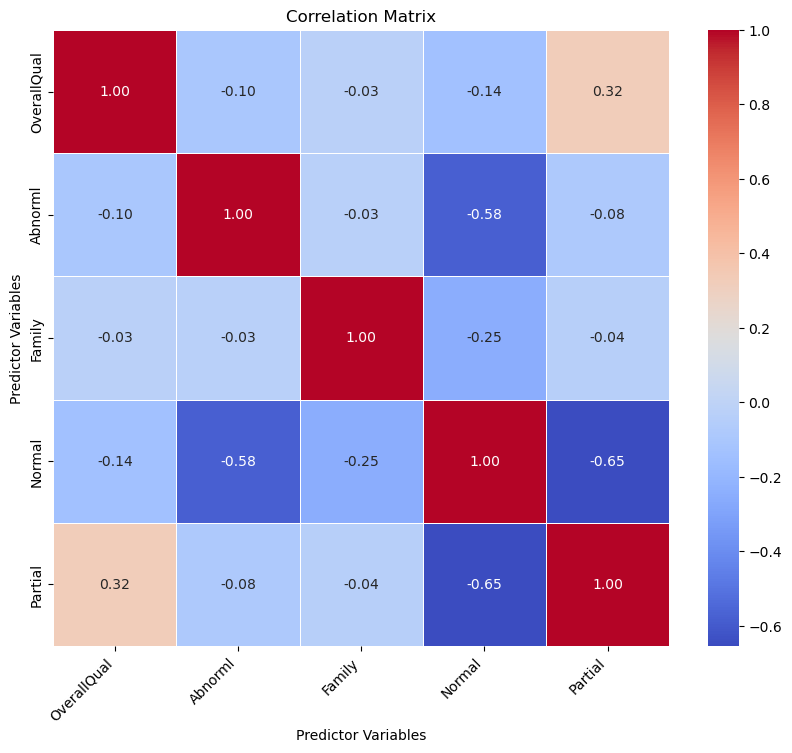

In [11]:
# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import plot_corr_matrix 

# Calculate correlation matrix
corr_matrix = X.corr()
fig = plot_corr_matrix(corr_matrix)
plt.savefig('..//fig//regression//assumptions//corrMat_multicollinearity.png', bbox_inches='tight', dpi=300, facecolor='white');
plt.show()

<img src="../fig/regression/assumptions/corrMat_multicollinearity.png"  align="center" width="60%" height="60%">

The Normal variable appears to be highly negatively correlated with both Partial and Abnormal. In fact, Normal has a considerable amount of negative corrleation with all predictors. If we think about our predictors holistically, it appears we have several categories describing somewhat rarer sale conditions, and then a more common/default "normal" condition. Regardless of the value of "Normal", if all other predictors are set to 0, that is a very good indication that it was a "Normal" sale. Since "Normal" tends to negate the remaining predictors presense and is redundant, it makes sense to remove it form the list of predictors and only consider the manner in which the sale was unusal. 

#### Correlation matrix vs VIF 
You might wonder why we even bother calculating the VIF score given that we could easily inspect the correlation matrices instead. VIF scores give a more reliable estimate of multicollinearity mainly due to their ability to assess multivariate interactions. That is, the correlation matrix only shows pairwise relationships between variables, but it does not reveal the impact of all independent variables simultaneously on each other. The VIF, on the other hand, takes into account all other independent variables when assessing multicollinearity for a specific variable. This individual assessment allows you to pinpoint which variables are causing multicollinearity issues. In addition, the VIF helps identify which variables are causing the problem, enabling you to take appropriate actions to address the issue. 

In summary, while the correlation matrix can give you a general idea of potential multicollinearity, the VIF score provides a more comprehensive and quantitative assessment, helping you identify, measure, and address multicollinearity issues in a regression model effectively.

In [12]:
X = X.drop('Normal',axis = 1)

In [13]:
X.columns

Index(['OverallQual', 'Abnorml', 'Family', 'Partial'], dtype='object')

After dropping the problematic variable with multicollinearity, we can recalculate VIF for each predictor in X. This time we'll call a helper function to save a little time.



VERIFYING MULTICOLLINEARITY...
      Variable       VIF
0      Abnorml  1.068003
1       Family  1.014579
2  OverallQual  1.237386
3      Partial  1.154805


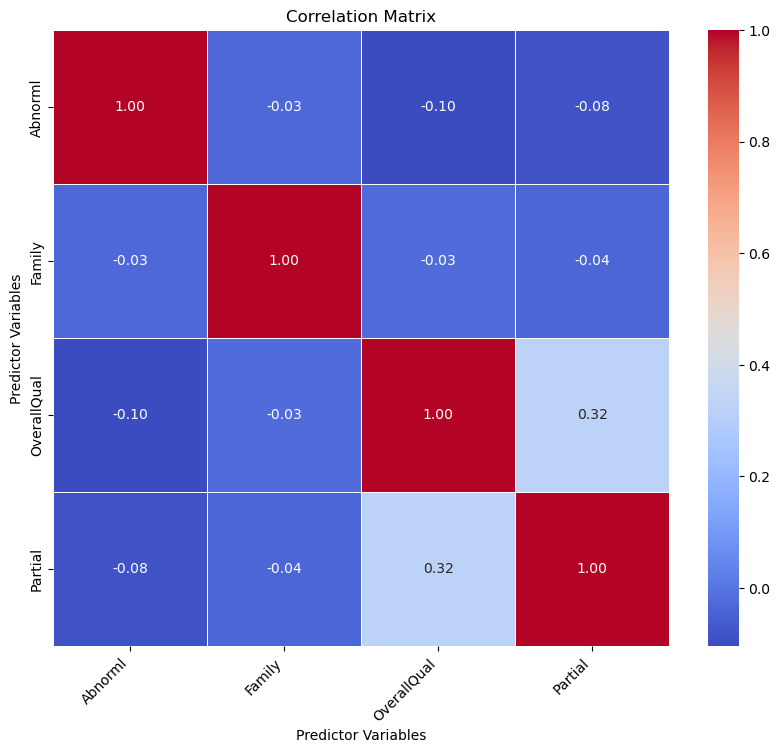

In [14]:
from check_assumptions import multicollinearity_test 
multicollinearity_test(X);

<img src="../fig/regression/assumptions/corrMat_multicollinearity2.png"  align="center" width="60%" height="60%">

Note that we still see some correlation between OverallQual and Partial. However, the correlation is not so strong that those predictors can be reasonably well predicted from one another (low VIF score).

### 3. Fit the model
Before we can assess the remaining assumptions of the model (linearity, normality, homoscedasticiy, and independence), we first must fit the model. 

#### Train/test split
Since we're working with multiple predictors, we must take care evaluate evidence of overfitting in this model. The test set will be left out during model fitting/training so that we can measure the model's ability to generalize to new data.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_log, 
                                                    test_size=0.33, 
                                                    random_state=4)

print(X_train.shape)
print(X_test.shape)

(978, 4)
(482, 4)


In [16]:
import statsmodels.api as sm

# Add a constant column to the predictor variables dataframe
X_train = sm.add_constant(X_train)

# Add the constant to the test set as well so we can use the model to form predictions on the test set later
X_test = sm.add_constant(X_test)
X_test.head()

,const,OverallQual,Abnorml,Family,Partial
280,1.0,7,0,0,0
1365,1.0,7,0,0,0
132,1.0,5,0,0,0
357,1.0,5,0,0,0
438,1.0,5,0,0,0


In [17]:
# Fit the multivariate regression model
model = sm.OLS(y_train, X_train)
trained_model = model.fit()

### 4. Evaluate evidence of overfitting or *severe* underfitting

Before we go any further in assessing the model's assumptions and ultimately running hypothesis tests, we should first check to see if there is evidence of overfitting or *severe* underfitting. 
- **Overfitting**: If R-squared is notably higher (accounting for sample size) in the test set than the train set, this indicates overfitting. Recall that overfitting means that the model will poorly generalize. When running hypothesis tests, the goal is typically to reveal general relationships that hold true across datasets. Therefore, overfitting must first be ruled out before we bother with hypothesis testing. 
- **Severe underfitting**: If the R-squared is extremely low in the train set, this indicates the model describes the data poorly and is underfitting. What consitutes a too low is dependent on your particular field of study. In the context of hypothesis testing, it is okay for predictors to have small but consistent effects (low R-squared). It's just when there is no noticeable effect that you might have to be concerned. Some researchers might consider R-squared values above 0.50 or 0.60 to be satisfactory in certain contexts. Others might find R-squared values as low as 0.20 or 0.30 to be meaningful, depending on many factors (dataset size, model relevance in ongoing studies, common benchmarks, etc.)



In [18]:
# to calculate residuals and R-squared for the test set, we'll need to get the model predictions first
y_pred_train = trained_model.predict(X_train)
y_pred_test = trained_model.predict(X_test)

# sklearn can help us quickly calculate R-squared 
from sklearn import metrics
R2_train = metrics.r2_score(y_train, y_pred_train) 
R2_test = metrics.r2_score(y_test, y_pred_test) 
print('train R2:', R2_train)
print('test R2:', R2_test)

train R2: 0.6656610907646398
test R2: 0.7039490404354984


You can also extract rsquared for the training data directly from the trained model.

In [19]:
# R-squared for train set
R2_train = trained_model.rsquared
print(R2_train)

0.6656610907646399


No evidence of overfitting (test and train errors are comparable) or severe underfitting (R-squared is not astonishingly low). You may notice that the test set R-squared is actually slightly higher than the train set R-squared. This may come as a surprise given that the test set was left out during model training. However, test set performance often can appear to be slightly better than train set simply given the limited number of samples often available in the test set.

### 5a) Check linearity assumption
The linearity assumption of multivariate regression states that the *overall relationship* between the predictors and the target variable should be approximately linear. This doesn't necessarily imply that each predictor must have a perfectly linear relationship. So long as the sum of combined effects is linear, then the linearity assumption has been met. That said, if you observe a strong nonlinear pattern between one or more predictors, this often does cascade into an overall nonlinear effect in the model. We will review one method to investigate each individual predictor's relationship with the target as well 

#### Why do we care?
As discussed in the previous episode, the predictions will be inaccurate because our model is underfitting (i.e., not adquately capturing the variance of the data since you can't effectively draw a line through nonlinear data). In addition to having a fatal impact on predictive power, violations of linearity can affect the validity of hypothesis tests on the regression coefficients. The p-values associated with the coefficients may not accurately reflect the statistical significance, potentially leading to erroneous conclusions.

#### Visualizing linearity in multivariate models
When working with univariate models, we are able to assess the linearity assumption PRIOR to model fitting simply by creating a scatterplot between the predictor and target. With multivariate models, however, we need a different approach in order to isolate the relationship between individual predictors and the target. That is, we need to account for effects of the remaining predictors. 

#### Partial regression plots
Partial regression plots, otherwise known as added variable plots, help visualize the relationship between a single predictor and the target variable while taking into account the effects of other predictor variables. By plotting the partial regressions against the target variable of interest, we can assess whether the relationship is approximately linear for each predictor. 

Partial regression plots are formed by:

1. Computing the residuals of regressing the target variable against the predictor variables but omitting Xi (predictor of interest)
2. Computing the residuals from regressing Xi against the remaining independent variables.
3. Plot the residuals from (1) against the residuals from (2).

By looking at the visualization, we can assess the impact of adding individual predictors to a model that has all remaining predictors. If we see a non-zero slope, this indicates a predictor has a meaningful relationship with the target after accounting for effects from other predictors.


eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


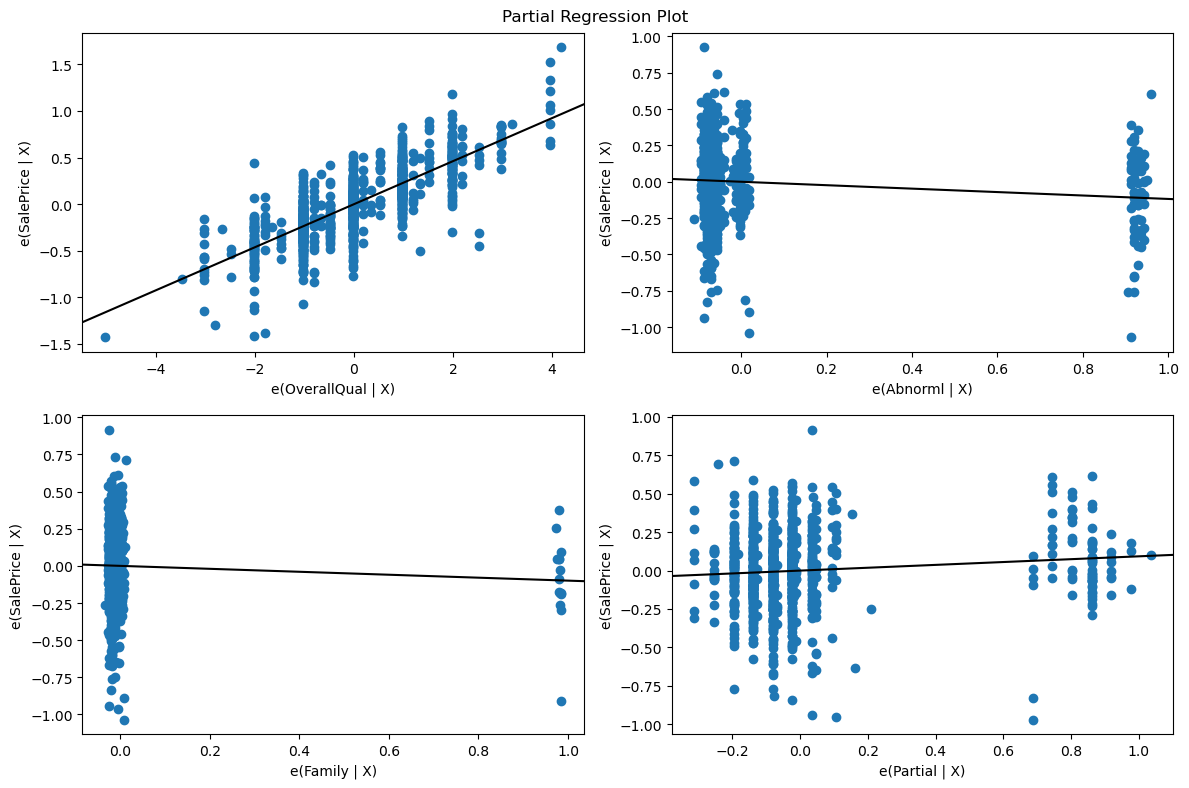

In [20]:
# Create the partial regression plots using statsmodels
import matplotlib.pyplot as plt
from statsmodels.graphics.regressionplots import plot_partregress_grid;

fig = plt.figure(figsize=(12, 8));
plot_partregress_grid(trained_model, fig=fig, exog_idx=list(range(1,X_train.shape[1])))
fig.savefig('..//fig//regression//assumptions//partialRegression.png', bbox_inches='tight', dpi=300, facecolor='white');

<img src="../fig/regression/assumptions/partialRegression.png"  align="center" width="30%" height="30%">

##### Inspect the plots
- You may notice how Partial and Abnormal now appear to be continuous predictors rather than binary predictors. This effect is commonly observed when you plot partial regressions of correlated predictors. Correlated predictors make it difficult to fully isolate the effect of just one predictor. However, the correlation is not so bad that we need to be concerned about the validity of our hypothesis tests later (based on the VIF scores we observed)
- The plots show the impact of adding each individual predictor while accounting for the remaining predictor effects
- The plot can be used to investigate whether or not each predictor has a linear relationship with the target
- Binary predictors will, by definition, always show a linear relationship since they will always have two means
- Some predictors, like Family, may show a non-zero slope, which indicates that this predictor is not really very useful in our model. We can wait until we run our hypothesis tests before fully excluding this predictor from the model

In conclusion, our model appears to be satisfying the linearity assumption based on these plots. 

### 5b) A more wholesome view of linearity (and homoscedasticity)
What if instead of 4 predictors, we have 100 predictors in our model? Partial regression plots can become burdensome to look through when working with many predictors. Furthermore, we still need to assess whether or not the overall relationship revealed by the model is linear or not. For this analysis, we can create two plots that both help evaluate both homoscedasticity and linearity. 

**Homoscedasticity** refers to when the variance of the model residuals is constant over all X values. Homoscedasticity
 is desirable because we want the residuals to be the same across all values of the independent variables / predictors. For hypothesis testing, confidence intervals, and p-values to be valid and meaningful, it is crucial that the underlying assumptions, including homoscedasticity, are met. If the assumption is violated, the inference drawn from the hypothesis tests may not be accurate.
 
We will call a pre-baked helper function to generate the plots and calculate a test statistic that assesses homoscedasticity (Goldfeld-Quandt test).

#### **Fig1.** Predictions vs actual values
* **Linearity:** We want to observe the data scattered about the diagonal to ensure the linearity assumption is met
* **Homoscedasticity (Constant Variance)**: If the variance of the data changes as you move along the X-axis, this indicates heterscedasticity

#### **Fig2.** Residuals vs predicted values
* **Linearity:** In the predicted vs residuals scatterplot, if we observe a random scattering of points around the red dashed line (y=0), it suggests that the linearity assumption is met. However, if we notice any patterns, such as a curved shape or a funnel-like structure, it might indicate a nonlinear relationship, and we may need to consider transformations or alternative modeling approaches to address the nonlinearity.
* **Homoscedasticity (Constant Variance)**: In the same plot, you examine whether the spread of the residuals remains consistent along the range of predicted values. If the spread of points around y = 0 does not change noticeably as you move along the x-axis (the predicted values), it suggests homoscedasticity.

#### **Goldfeld-Quandt test**
The Goldfeld-Quandt test is a statistical test used to check for heteroscedasticity (unequal variances) in a regression model. It splits the data into two groups based on a specified split point (default is the median) and then estimates separate variances for each group. The test statistic is calculated based on the F-distribution, and the p-value is obtained by comparing the test statistic to the critical value from the F-distribution. If the p-value is greater than your chosen significance level (e.g., 0.05), you fail to reject the null hypothesis, indicating no evidence of heteroscedasticity. In this case, the variance of residuals is assumed to be equal for both groups.
If the p-value is less than your significance level, you can reject the null hypothesis, suggesting the presence of heteroscedasticity. This means that the variance of residuals is different for different groups, indicating potential issues with the regression model's assumptions.


VERIFYING LINEARITY & HOMOSCEDASTICITY...

 Goldfeld-Quandt test (homoscedasticity) ----
                value
F statistic  0.920670
p-value      0.818216

 Residuals plots ----


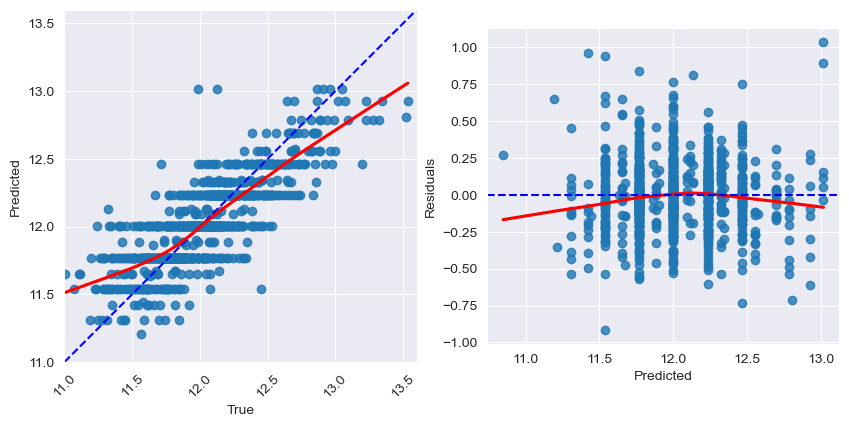

In [21]:
from check_assumptions import homoscedasticity_linearity_test 
fig = homoscedasticity_linearity_test(trained_model, y_train, y_pred_train)
fig.savefig('..//fig//regression//assumptions//linearity-homoscedasticity_pred_v_residuals.png',bbox_inches='tight', dpi=300)


<img src="../fig/regression/assumptions/linearity-homoscedasticity_pred_v_residuals.png"  align="center" width="40%" height="40%">

### Inspect the plot and Goldfeld-Quandt test

#### **Fig1.** Predictions vs actual values
* **Linearity:** While the model is somewhat linear, it appears to be overestimating the value of low-cost homes while underestimating the most expensive homes.
* **Homoscedasticity (Constant Variance)**: The variance of the data appears to be mostly consistent across the diagonal. 

#### **Fig2.** Residuals vs predicted values
* **Linearity**: The errors have some curvature across predicted values indicating that the linearity assumption is again questionable with this data. 
* **Homoscedasticity**: The errors here are fairly consistently distributed across the x-axis


#### How to remedy issues with linearity
If you encounter issues with the linearity assumption, you can try the following solutions:
1. **Transformations**: Apply nonlinear transformations to X and/or Y. Common transformations are the natural logarithm, square root, and inverse. A Box-Cox transformation of the outcome may help, as well. Partial regression plots can help identify predictors that have a nonlinear relationship with Y.
2. **Remove nonlinear predictors**: Remove predictors that exhibit a nonlinear trend with the target (e.g., via inspecting partial regression plots)
3. **Limit range of training data**: With data like ours, you could try to limit the training data to sale prices in the 25-75th percentile range. This would yield an accurate (linear) description of the data, but the model would not generalize well to sale prices outside this range. If your goal is only to describe data and not extrapolate to unseen datasets, this approach may be sufficient.
3. **Adding additional predictors:** Add predictors to help capture the relationship between the predictors and the label. Remember, we really just need the overall relationship between target and predictors to be linear. Sometimes, adding additional predictors that relate to the target can help produce an overall linear model. With our housing data, there may be 
4. **Try spline or polynomial regression**: In polynomial regression, you add polynomial terms to some of the predictors (i.e., polynomial regression). In a similar vein to solution 1, polynomial regression will allow you to include transformed predictors which may linearly relate to the target. Spline regression is similar, however, it allows you to fit separate polynomials to different segments of the data

If none of those approaches work, you can also consider nonlinear models if you have a sufficiently large dataset (learning nonlinear relationships requires lots of data).

### 5. Evaluate normality of residuals & constant variance (homoscedasticity) of residuals 
Given that the linearity assumption is in question with this model, we would typically begin exploring alternative models/predictors/transformations for our analysis. However, we will check the remaining assumptions here as practice for future work. 

**Normal residuals**: In a linear regression model, it is assumed that the model residuals/errors are normally distributed. If the residuals are not normally distributed, their randomness is lost, which implies that the model is not able to explain the relation in the data.

Many statistical tests and estimators used in multivariate regression, such as t-tests and confidence intervals, also rely on the assumption of normality. If the residuals are not approximately normally distributed, the results of these tests and estimators may be invalid or biased.

#### Histograms
Histograms can help give a preliminary sense of the overall distribution of the data. We can also quickly calculate the "skew" of a distribution using numpy's skew() function.

Median of residuals: 0.004774460786039825


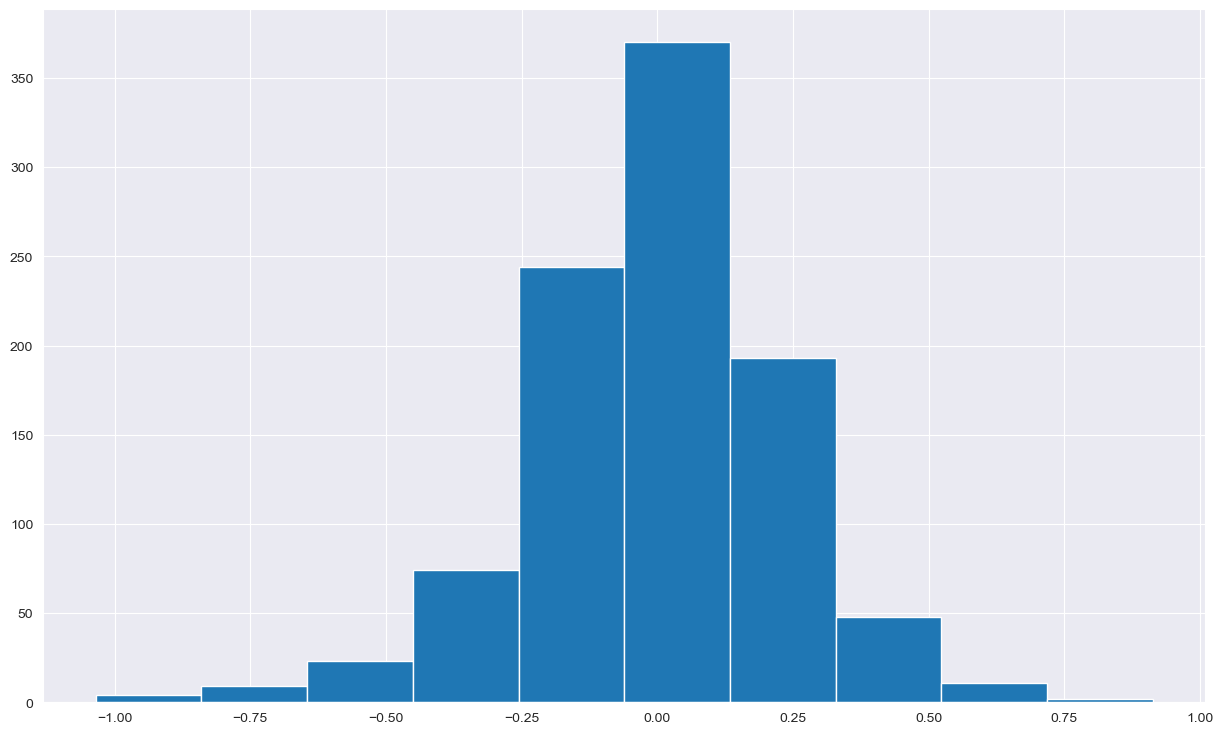

In [22]:
# Extract the residuals and calculate median — should lie close to 0 if it is a normal distribution
resids = y_train - y_pred_train
print('Median of residuals:', np.median(resids))
plt.hist(resids);
resids.skew() 
plt.savefig('..//fig//regression//assumptions//normal_resids_histogram.png',bbox_inches='tight', dpi=300)


<img src="../fig/regression/assumptions/normal_resids_histogram.png"  align="center" width="40%" height="40%">

#### Quantile-quantile (QQ) plots
While histograms are helpful as a preliminary glance at the data, it can be difficult to tell by eye just how different the distribution is from a normal distribtion. Instead, we can use a popular type of plot known as a  **quantile-quantile plot (QQ-plot)** of the model residuals. Quantiles — often referred to as percentiles — indicate values in your data below which a certain proportion of the data falls. For instance, if data comes from a classical bell-curve Normal distrubtion with a mean of 0 and a standard deviation of 1, the 0.5 quantile, or 50th percentile, is 0 (half the data falls above 0, half below zero). 

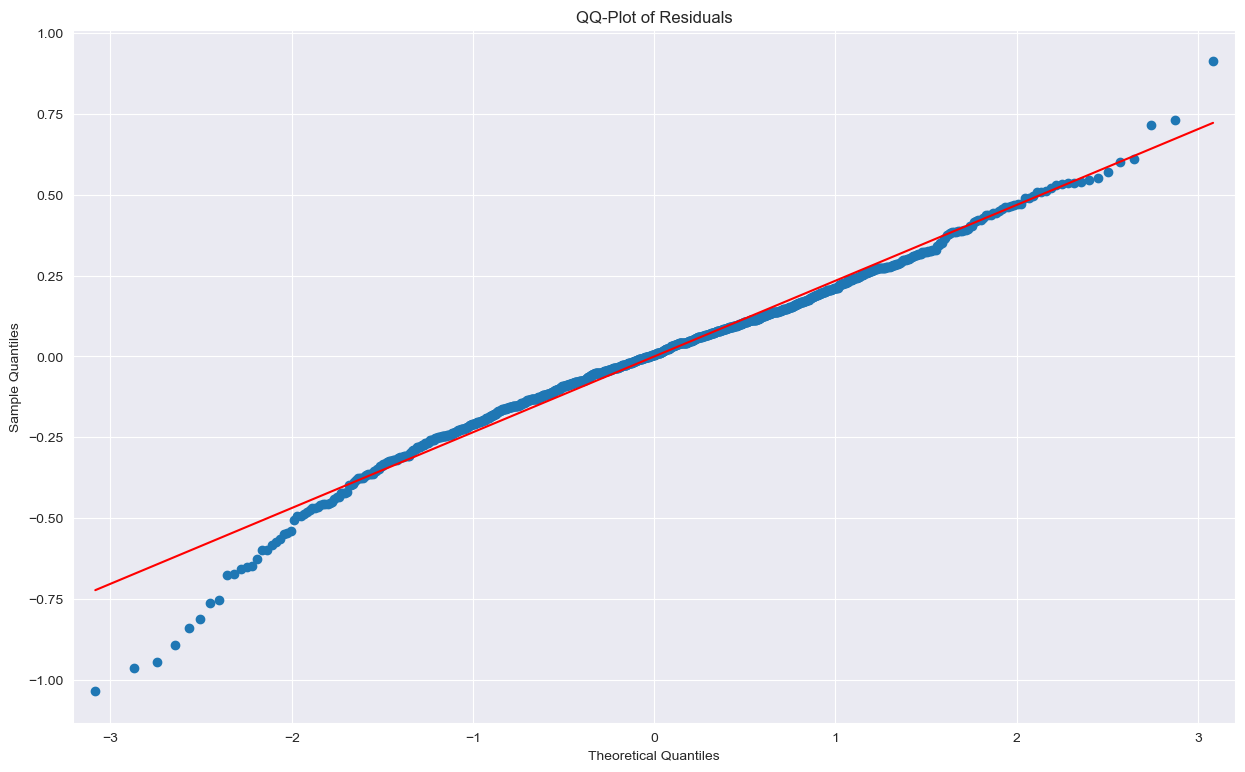

In [23]:
import statsmodels.graphics.gofplots as smg

# Plot the QQ-plot of residuals
smg.qqplot(resids, line='s')

# Add labels and title
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ-Plot of Residuals')

plt.savefig('..//fig//regression//assumptions//normal_resids_QQplot.png',bbox_inches='tight', dpi=300)

<img src="../fig/regression/assumptions/normal_resids_QQplot.png"  align="center" width="40%" height="40%">

#### Unpacking the QQ-plot
To construct a QQ-plot, the raw data is first sorted from smaller to larger values. Then, empirical quantiles can be assigned to each sample in the dataset. These measurements can then be compared to theoretical quantiles from a normal distribution. Oftentimes, QQ-plots show zscores rather than actual quantile values since zscores can be interpreted more easily. 

**X-axis: Theoretical Quantiles**
This x-axis represents nothing but Z-values/Z-scores of standard normal distribution.
0.5 quantile corresponds to 50th percentile i.e. at 0 Z-score.
90th percentile is approximately 1.282.
0.25 quantile or 25th percentile means -0.67 Z-score.
0.75 quantile or 75th percentile represents 0.67 Z-score.

**Y-axis: Sample Quantiles**
The y-axis captures the true z-scores of each observed sample in our dataset. The observed z-score can be compared to the expected z-score based on a datapoint's position in an ordered dataset.

**Red diagonal line**
Data drawn from a normal distribution fall along the line y = x in the Q-Q plot.

**Common Diagnostics**
1. **Right-skewed**: If the data falls above the red line (where y=x) where x > 0, that means that you have a right skewed distrution (long tail on the right side of the distrubtion). A right-skewed distribution will have have higher than expected z-scores for data that is greater than the mean (zscore = 0).
2. **Left-skewed**: If the data falls below the red line (where y=x) where x < 0, that means that you have a left skewed distrution (long tail on the left side of the distrubtion). This causes the sample distribtuion to have lower (more negative) than expected z-scores for data that is greater than the mean (zscore = 0).
3. **Long tails / tall peak**: Combination of 1&2 above — points below the mean (zscore = 0) will fall below the red line, and points above the mean will fall above the red line

#### Quantitative assessments of normality
**Shapiro-Wilk test and Kolmogorov–Smirnov tests**: There are a couple of methods that can yield quantiative assessments of normality. However, they are both very sensitive to sample size and pale in comparison to visual inspection of the residuals (via histogram/density plot or a QQ-plot). With larger sample sizes (>1000 observations), even minor deviations from normality may lead to rejecting the null hypothesis, making these tests less useful.

In [24]:
# 
from scipy import stats
shapiro_stat, shapiro_p = stats.shapiro(resids)
print(f"Shapiro-Wilk test: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.10f}")

# Perform the Kolmogorov-Smirnov test on the test_residuals
ks_stat, ks_p = stats.kstest(resids, 'norm')
print(f"Kolmogorov-Smirnov test: statistic={ks_stat:.4f}, p-value={ks_p:.10f}")

# Display the plot (assuming you have implemented a plot in your function)
plt.show()

Shapiro-Wilk test: statistic=0.9825, p-value=0.0000000019
Kolmogorov-Smirnov test: statistic=0.3115, p-value=0.0000000000


#### Causes of non-normal residuals

Violations of normality often arise due to... 
- Outliers present in the target variable
- Violations of the linearity assumption: If the relationship between the dependent variable and one or more predictor variables is nonlinear, the residuals may show a pattern that deviates from normality. Nonlinear relationships can cause the model to under- or overestimate the dependent variable, leading to non-normal residuals.
- Violations of homoscedasticity: Non-constant variance can lead to residuals that have a non-normal distribution, particularly if the variance increases or decreases systematically with the predicted values.
- M-issing Predictor Variables: Omitted variable bias can occur when important predictor variables are not included in the model. If these omitted variables are related to the dependent variable, the residuals can deviate from normality.

Later in the workshop, we can use the following helper function to run the normality tests/visualizations.


VERIFYING NORMAL ERRORS...
Median of residuals: 0.004774460786039825
Shapiro-Wilk test: statistic=0.9825, p-value=0.0000000019
Kolmogorov-Smirnov test: statistic=0.3115, p-value=0.0000000000


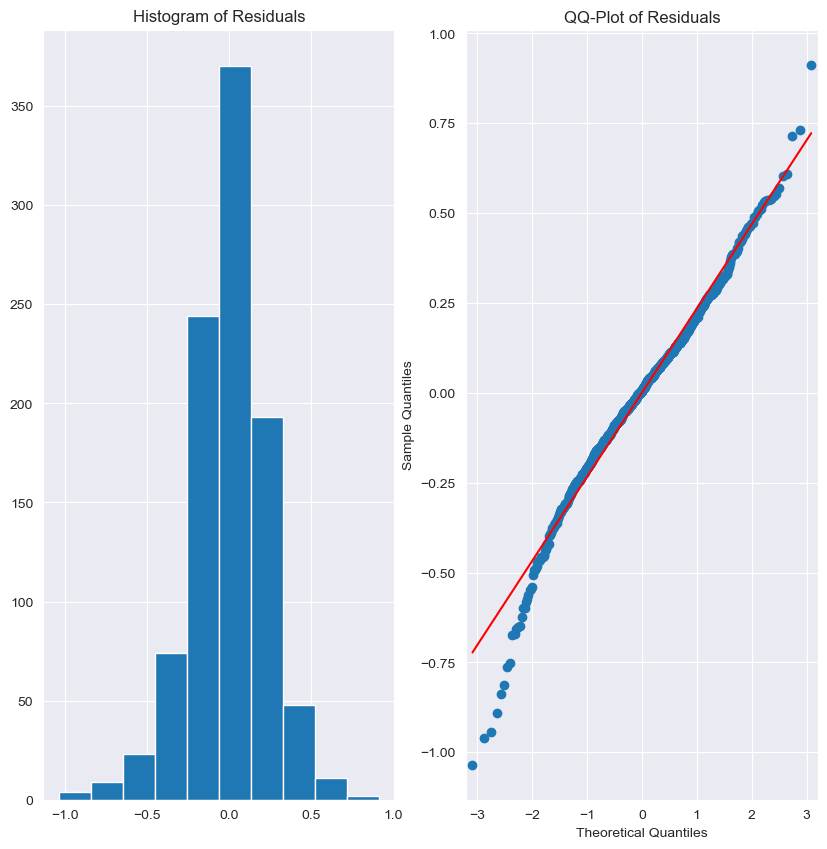

In [25]:
from check_assumptions import normal_resid_test
fig = normal_resid_test(resids)
fig.savefig('..//fig//regression//assumptions//normal_resids_fullTest.png',bbox_inches='tight', dpi=300)

### 6. Independent errors test 
**Independent errors assumption**: In the context of linear regression, the independent errors assumption states that the errors (also called residuals) in the model are not correlated with each other. In other words, the residual for one observation should not provide any information or pattern that can help predict the residual for another observation. This assumption is crucial because if errors are correlated, it can lead to biased and inefficient estimates of the regression coefficients, affecting the validity of the statistical inference and prediction.

Mathematically, for a linear regression model, the independent errors assumption can be written as:

Corr(εi, εj) = 0 for all i ≠ j

Where:

* εi is the error (residual) for the ith observation.
* εj is the error (residual) for the jth observation.
* Corr(εi, εj) represents the correlation between the errors for the ith and jth observations.

#### Durbin-Watson Test
The Durbin-Watson test is a statistical test that checks for autocorrelation in the residuals. If the residuals are independent, there should be no significant autocorrelation. The test statistic ranges between 0 and 4. A value around 2 indicates no autocorrelation, while values significantly below 2 indicate positive autocorrelation, and values above 2 indicate negative autocorrelation. You can use the statsmodels library to calculate the Durbin-Watson test statistic:

In [26]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson_statistic = durbin_watson(resids)
print(f"Durbin-Watson test statistic: {durbin_watson_statistic}")

Durbin-Watson test statistic: 1.9864287360736377


It can also be helpful to re-examine the model predictions vs residual plot to look for violations of this assumption. If the errors are independent, the residuals should be randomly scattered around zero with no specific patterns or trends. We'll call a pre-baked helper function to quickly create this plot and run the Durbin-Watson test.



VERIFYING INDEPENDENT ERRORS...
Durbin-Watson test statistic: 1.9864287360736377


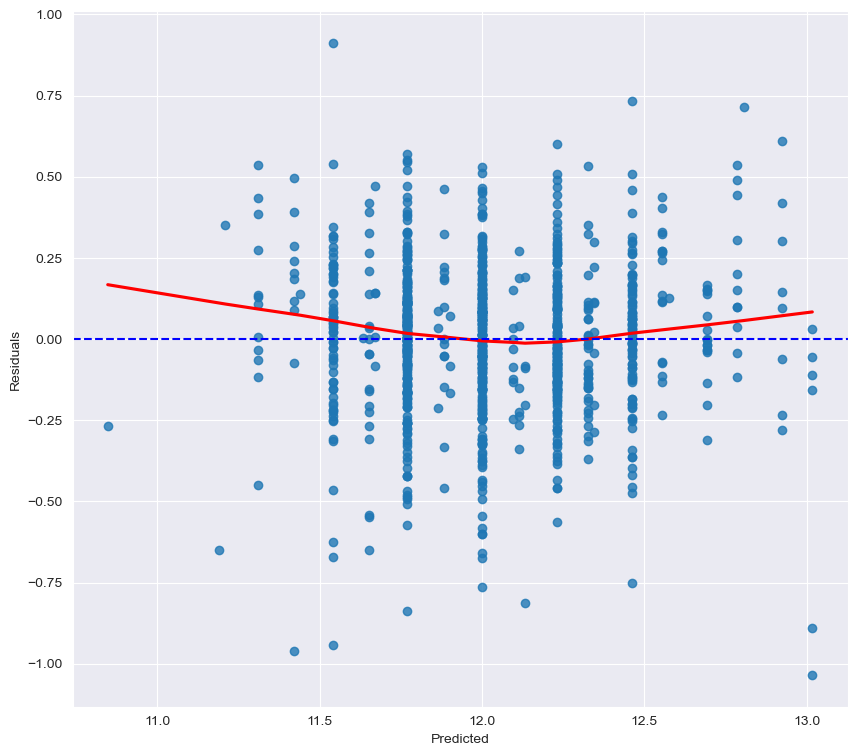

In [27]:
from check_assumptions import independent_resid_test
fig = independent_resid_test(y_pred_train, resids, include_plot=True)
fig.savefig('..//fig//regression//assumptions//independentResids_fullTest.png',bbox_inches='tight', dpi=300)

#### Running all assumptions tests at once


VERIFYING MULTICOLLINEARITY...
      Variable       VIF
0      Abnorml  1.067576
1       Family  1.015308
2  OverallQual  1.226972
3      Partial  1.144088


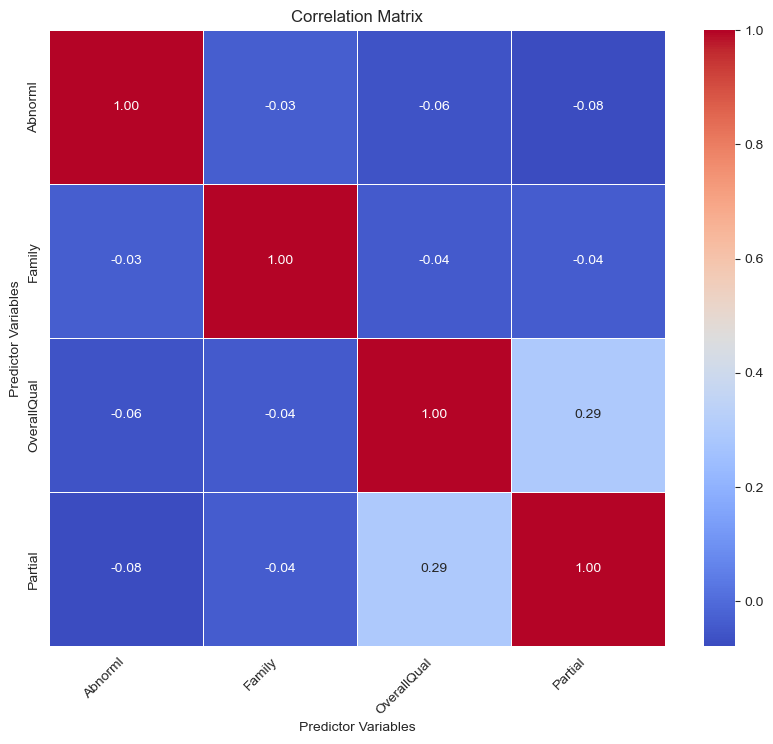


VERIFYING LINEARITY & HOMOSCEDASTICITY...

 Goldfeld-Quandt test (homoscedasticity) ----
                value
F statistic  0.920670
p-value      0.818216

 Residuals plots ----


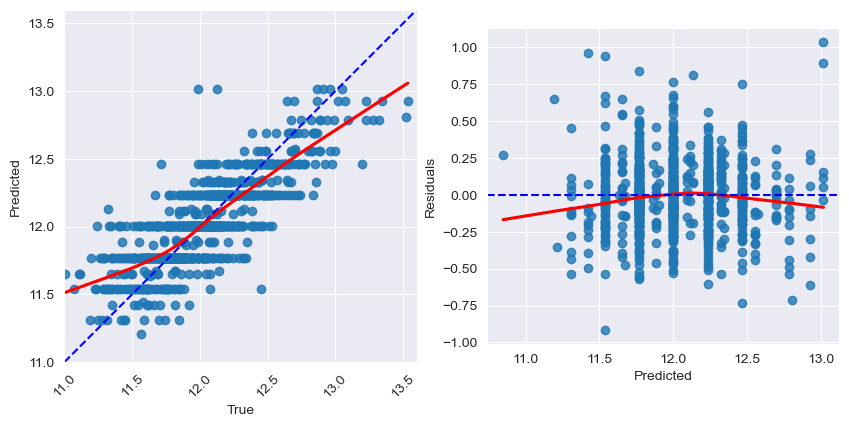


VERIFYING NORMAL ERRORS...
Median of residuals: 0.004774460786039825
Shapiro-Wilk test: statistic=0.9825, p-value=0.0000000019
Kolmogorov-Smirnov test: statistic=0.3115, p-value=0.0000000000


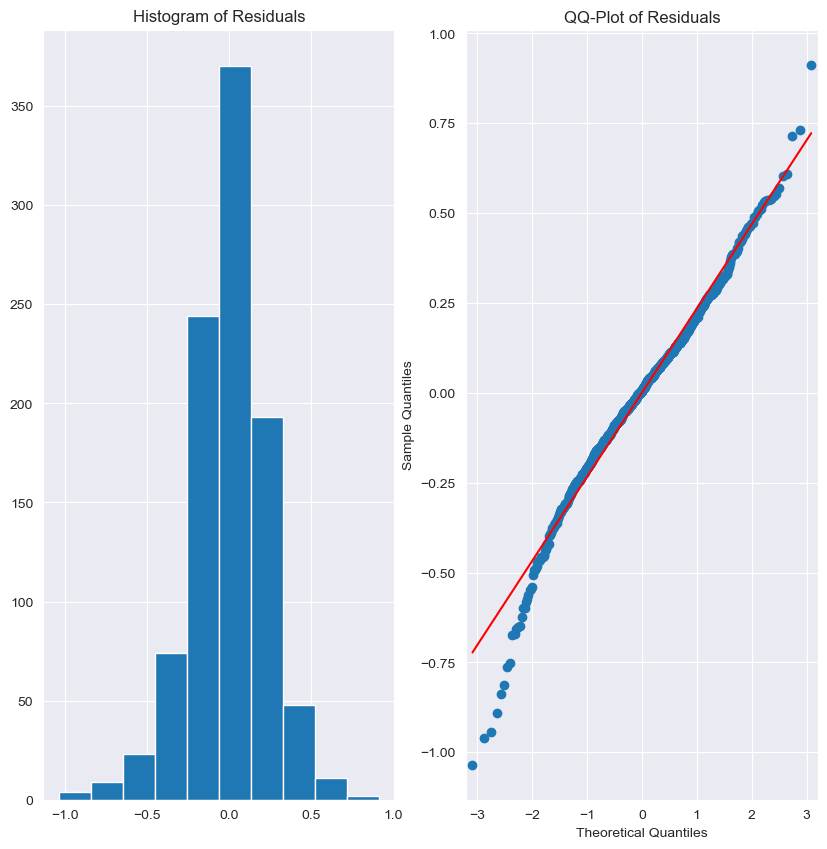


VERIFYING INDEPENDENT ERRORS...
Durbin-Watson test statistic: 1.9864287360736377


In [28]:
from check_assumptions import eval_regression_assumptions
eval_regression_assumptions(trained_model, X_train, y_train, y_pred_train);

In [29]:
X_train.columns

Index(['const', 'OverallQual', 'Abnorml', 'Family', 'Partial'], dtype='object')

### Exploring an alternative set of predictors
Now that you know how to assess the 5 assumptions of linear regression, try validating a multivariate linear model that predicts log(SalePrice) from the following predictors:

* LotArea
* YearBuilt
* YearRemodAdd
* GarageArea
* GarageCars
* Neighborhood

**1. First, extract the data you'll be using to fit the model.**

```
y_log = np.log(housing['target']) 
predictors = ['LotArea', 'YearBuilt', 'YearRemodAdd', 'GarageArea', 'GarageCars', 'Neighborhood'] 
X=housing['data'][predictors]
```

**2. Next, preprocess the data.**

a. Check to see if there are any categorical predictors. If so, encode those predictors using "one-hot encoding".

```
one_hot = pd.get_dummies(X[cat_predictor])

# Join the encoded df
X = X.join(one_hot)

# Drop column SaleCondition as it is now encoded
X = X.drop(cat_predictor,axis = 1)
X.head()
```

b. Check if there are any predictors/features which are too sparse. Remove any predictors that are >= 99% sparse.

```
nonzero_counts = X.astype(bool).sum()
print(nonzero_counts)
print(nonzero_counts/X.shape[0]*100)
```


3. First check the multicollinearity assumption. If this assumption is violated, remove the problematic predictors that cause multicollinearity. Remember that you should recalculate the VIF score each time you remove a predictor.

4. Check all remaining assumptions using eval_regression_assumptions()



In [ ]:
#### EXERCISE_START: Exploring an alternative set of predictors


#### EXERCISE_SOLUTION

#### EXERCISE_END

In [30]:
housing['data'].columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [48]:
len(housing['data']['Neighborhood'].unique())
# one_hot_encoded_target = pd.get_dummies(housing['data']['Neighborhood'])
# X = pd.concat([X, log_sale_price], axis=1)
# X.head()

25

In [ ]:
# continuous_fields=['LotFrontage','LotArea','YearBuilt','YearRemodAdd',
#                   'OverallQual','OverallCond','MasVnrArea','BsmtFinSF1',  
#                   'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
#                   '2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath',
#                   'BsmtHalfBath','FullBath','HalfBath','KitchenAbvGr','BedroomAbvGr',
#                   'TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
#                   'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
#                   '3SsnPorch','ScreenPorch','PoolArea','YrSold','MoSold']

Extract target, `y` and predictors, `X`.

In [37]:
y_log = np.log(housing['target']) 
predictors = ['LotArea', 'YearBuilt', 'YearRemodAdd', 'GarageArea', 'GarageCars', 'Neighborhood'] 
X=housing['data'][predictors]
X.head()

Preprocess the data

In [42]:
from preprocessing import encode_predictors_housing_data
X_encoded = X.copy(deep=True) 
X_encoded = encode_predictors_housing_data(X_encoded)
X_encoded.head()

from preprocessing import remove_bad_cols
X_encoded_good = remove_bad_cols(X_encoded, .95)
X_encoded_good.head()

print(X_encoded_good.shape)
print(y.shape)
print(X_encoded_good.columns)

# of columns removed: 16
Columns removed: ['Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NPkVill', 'Neighborhood_NoRidge', 'Neighborhood_SWISU', 'Neighborhood_SawyerW', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker']
(1460, 14)
(1460,)
Index(['Neighborhood_CollgCr', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_NAmes', 'Neighborhood_NWAmes', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_Sawyer', 'Neighborhood_Somerst',
       'YearRemodAdd', 'GarageCars', 'GarageArea', 'YearBuilt', 'LotArea'],
      dtype='object')


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded_good, y_log, test_size=0.33)

In [44]:
# Add a constant column to the predictor variables dataframe
X_train = sm.add_constant(X_train)

# Add the constant to the test set as well so we can use the model to form predictions on the test set later
X_test = sm.add_constant(X_test)
X_test.head()
# Fit the multivariate regression model
model = sm.OLS(y_train, X_train)
trained_model = model.fit()

In [46]:
# to calculate residuals and R-squared for the test set, we'll need to get the model predictions first
y_pred_train = trained_model.predict(X_train)
y_pred_test = trained_model.predict(X_test)


VERIFYING MULTICOLLINEARITY...
                Variable          VIF
0             GarageArea    30.485737
1             GarageCars    35.081461
2                LotArea     2.489479
3   Neighborhood_CollgCr     1.405041
4   Neighborhood_Edwards     1.264577
5   Neighborhood_Gilbert     1.233108
6     Neighborhood_NAmes     1.518176
7    Neighborhood_NWAmes     1.178625
8   Neighborhood_NridgHt     1.309585
9   Neighborhood_OldTown     1.500214
10   Neighborhood_Sawyer     1.189338
11  Neighborhood_Somerst     1.248233
12             YearBuilt  9924.468372
13          YearRemodAdd  9814.888760


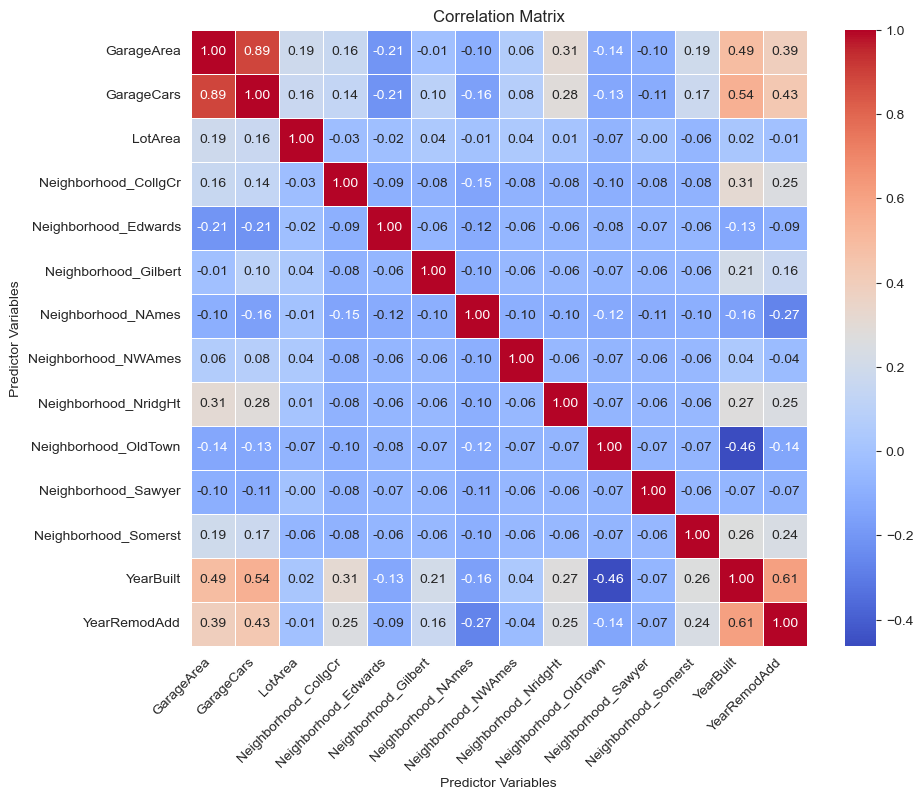


VERIFYING LINEARITY & HOMOSCEDASTICITY...

 Goldfeld-Quandt test (homoscedasticity) ----
                value
F statistic  0.926533
p-value      0.796761

 Residuals plots ----


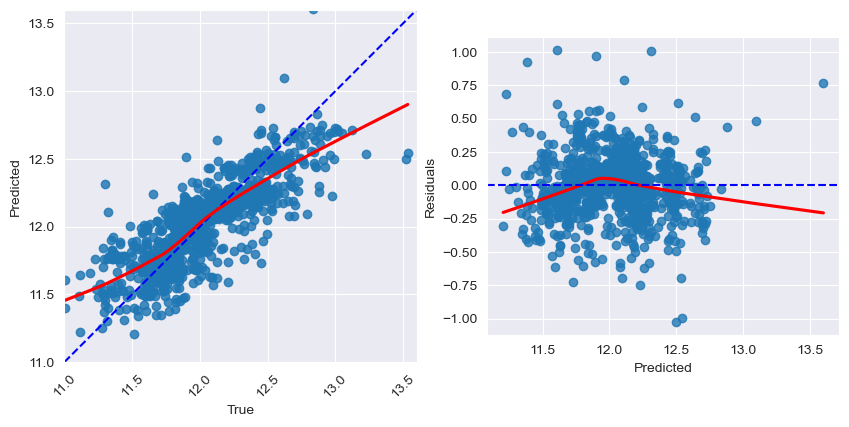


VERIFYING NORMAL ERRORS...
Median of residuals: -0.00015663156790513
Shapiro-Wilk test: statistic=0.9806, p-value=0.0000000004
Kolmogorov-Smirnov test: statistic=0.3077, p-value=0.0000000000


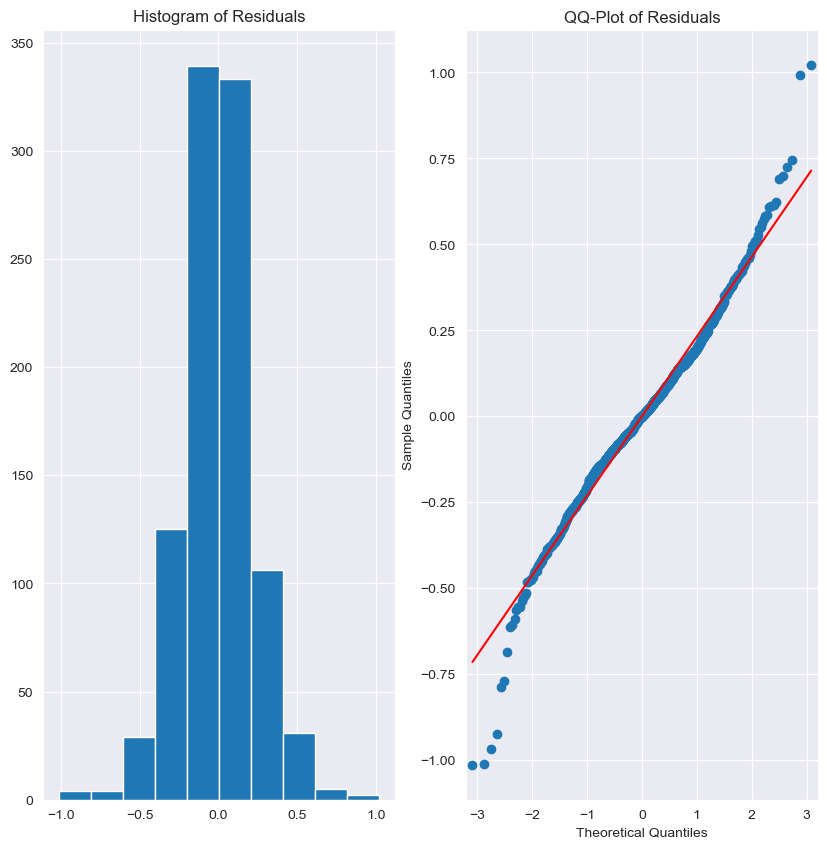


VERIFYING INDEPENDENT ERRORS...
Durbin-Watson test statistic: 1.9972526684069372


In [47]:
eval_regression_assumptions(trained_model, X_train, y_train, y_pred_train);